In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
dataPath = "/content/drive/MyDrive/Colab Notebooks/DL project/Land Cover Classification/Data"
os.chdir(dataPath)
IMAGE_SIZE = 320
BATCH_SIZE = 7
EPOCHS = 25

color_dict = pd.read_csv('class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [3]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("train/*.jpg")), 
    'MASKS': sorted(glob("train/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

,IMAGES,MASKS
0,train/951120_sat.jpg,train/951120_mask.png
1,train/584941_sat.jpg,train/584941_mask.png
2,train/627806_sat.jpg,train/627806_mask.png
3,train/111335_sat.jpg,train/111335_mask.png
4,train/19627_sat.jpg,train/19627_mask.png


In [4]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

In [5]:
from PIL import Image

def getCats(path):
    mask = Image.open(path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
    mask = np.array(mask)
    mask = rgb2category(mask)
    return mask

def processMask(df):
    for cls in CLASSES:
        df[cls] = 0

    for i in tqdm(range(len(df))):
        mask = getCats(df['MASKS'][i])
        onehot = [0]*7
        for idx in np.unique(mask):
            onehot[idx]=1
        df.loc[i, 2:] = onehot
    return df  

In [14]:
df = processMask(pd_dataset)
df.head()

  0%|          | 0/803 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
100%|██████████| 803/803 [02:20<00:00,  5.70it/s]


,IMAGES,MASKS,urban_land,agriculture_land,rangeland,forest_land,water,barren_land,unknown
0,train/256189_sat.jpg,train/256189_mask.png,1,1,1,0,1,0,0
1,train/651312_sat.jpg,train/651312_mask.png,1,1,1,1,1,1,0
2,train/987381_sat.jpg,train/987381_mask.png,1,1,1,0,1,0,1
3,train/636849_sat.jpg,train/636849_mask.png,1,1,1,0,1,1,0
4,train/393043_sat.jpg,train/393043_mask.png,1,1,0,0,1,0,0


In [18]:
clsdf = [
    ['urban_land', df['urban_land'].sum()],
    ['agriculture_land', df['agriculture_land'].sum()],
    ['rangeland', df['rangeland'].sum()],
    ['forest_land', df['forest_land'].sum()],
    ['water', df['water'].sum()],
    ['barren_land', df['barren_land'].sum()],
    ['unknown', df['unknown'].sum()],
]

clsdf = pd.DataFrame(clsdf, columns=["Category", "Instances"])
clsdf.head()

,Category,Instances
0,urban_land,800
1,agriculture_land,722
2,rangeland,521
3,forest_land,191
4,water,471


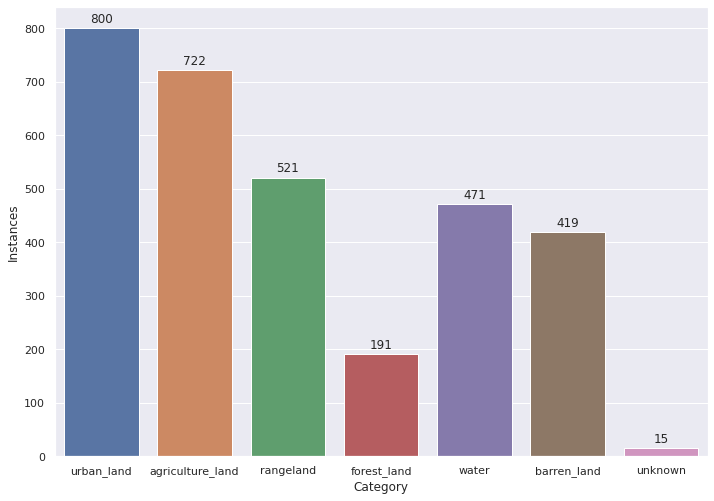

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x = 'Category',
            y = 'Instances',
            data = clsdf,
            errwidth=0)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 10.5, clsdf['Instances'][i],ha="center")

In [36]:
corr = df.iloc[:,2:].corr()
corr.style.background_gradient(cmap='coolwarm')

,urban_land,agriculture_land,rangeland,forest_land,water,barren_land,unknown
urban_land,1.000000,0.047268,0.083236,-0.013732,0.072939,0.063967,0.008449
agriculture_land,0.047268,1.000000,0.030789,-0.084820,-0.138462,-0.188201,-0.014872
rangeland,0.083236,0.030789,1.000000,0.153652,0.161090,0.042543,0.062967
forest_land,-0.013732,-0.084820,0.153652,1.000000,-0.113034,0.019542,-0.033871
water,0.072939,-0.138462,0.161090,-0.113034,1.000000,0.097379,0.059802
barren_land,0.063967,-0.188201,0.042543,0.019542,0.097379,1.000000,0.003187
unknown,0.008449,-0.014872,0.062967,-0.033871,0.059802,0.003187,1.000000


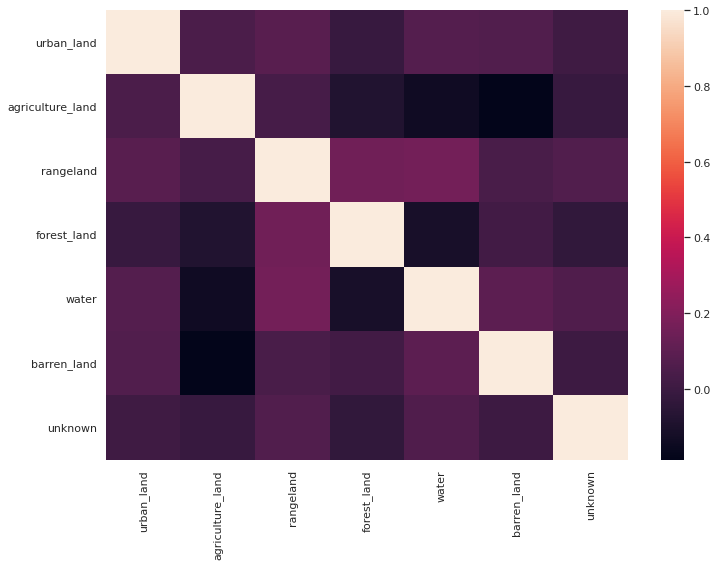

In [37]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [3]:
deeplabv3 = [
    {
    'Encoder': 'Resnet18',
    'Loss': 0.4196537733078003,
    'IoU': 0.6994313597679138,
    'Accuracy': 0.9422793984413147,
    'Precision': 0.7979775667190552,
    'Recall': 0.7979775667190552,
    'F1score': 0.7979775667190552
    },
    {
    'Encoder': 'Resnet50',
    'Loss': 0.4123762547969818,
    'IoU': 0.7262035608291626,
    'Accuracy': 0.9491825103759766,
    'Precision': 0.8221387267112732,
    'Recall': 0.8221387267112732,
    'F1score': 0.8221387267112732
    },
    {
    'Encoder': 'Resnet101',
    'Loss': 0.39198556542396545,
    'IoU': 0.721318781375885,
    'Accuracy': 0.9481917023658752,
    'Precision': 0.8186715245246887,
    'Recall': 0.8186715245246887,
    'F1score': 0.8186715245246887
     }
]

dlv3df = pd.DataFrame(deeplabv3)
dlv3df

,Encoder,Loss,IoU,Accuracy,Precision,Recall,F1score
0,Resnet18,0.419654,0.699431,0.942279,0.797978,0.797978,0.797978
1,Resnet50,0.412376,0.726204,0.949183,0.822139,0.822139,0.822139
2,Resnet101,0.391986,0.721319,0.948192,0.818672,0.818672,0.818672


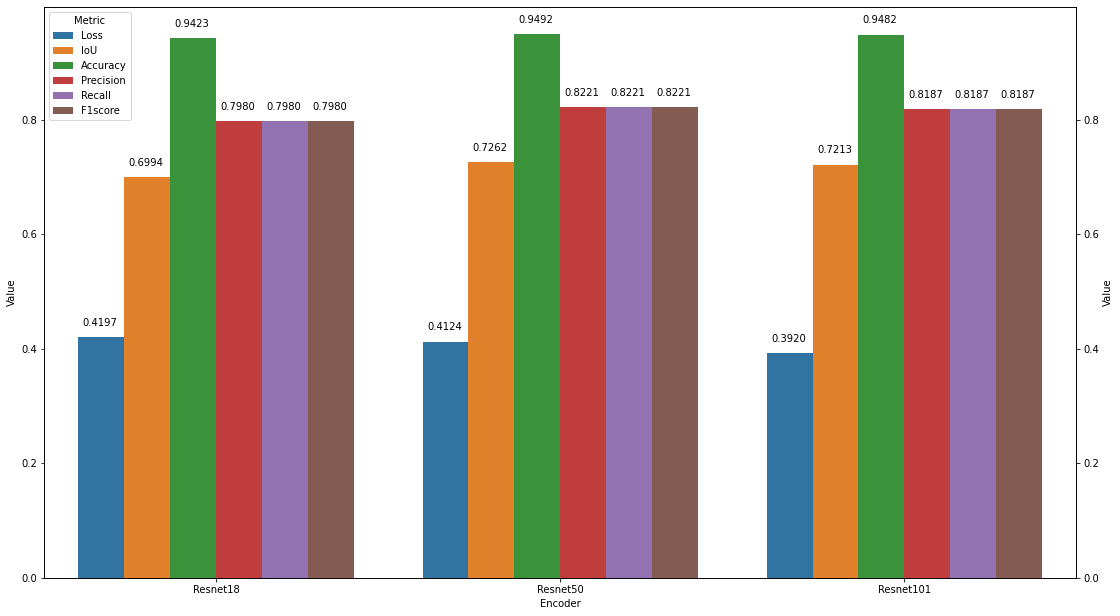

In [30]:
import seaborn as sns
test_data_melted = pd.melt(dlv3df, id_vars="Encoder",\
                           var_name="Metric", value_name="Metrics")
# Plot
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)
g = sns.barplot(x=dlv3df.columns[0], y="Metrics", hue="Metric",\
                data=test_data_melted, ax=ax1)

# Create a second y-axis with the scaled ticks
ax1.set_ylabel('Value')
ax2 = ax1.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round(ax1.get_yticks(),1))
ax2.set_ylabel('Value')

for i, p in enumerate(ax1.patches):
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/4.+0.03, height + 0.02, "{:.4f}".format(test_data_melted['Metrics'][i]),ha="center")
plt.show()


In [8]:
# MaskRCNN
loss = [0.0535, 0.0451, 0.0427, 0.0434, 0.0418, 0.0389, 0.0376, 0.0369, 0.0387, 0.0377, 0.0357, 0.0369, 0.0380, 0.0367, 0.0369]
APIOU = [0.089, 0.197, 0.213, 0.155, 0.165, 0.287, 0.149, 0.149, 0.149, 0.149, 0.149, 0.151, 0.149, 0.149, 0.149]
assert len(loss)==len(APIOU)

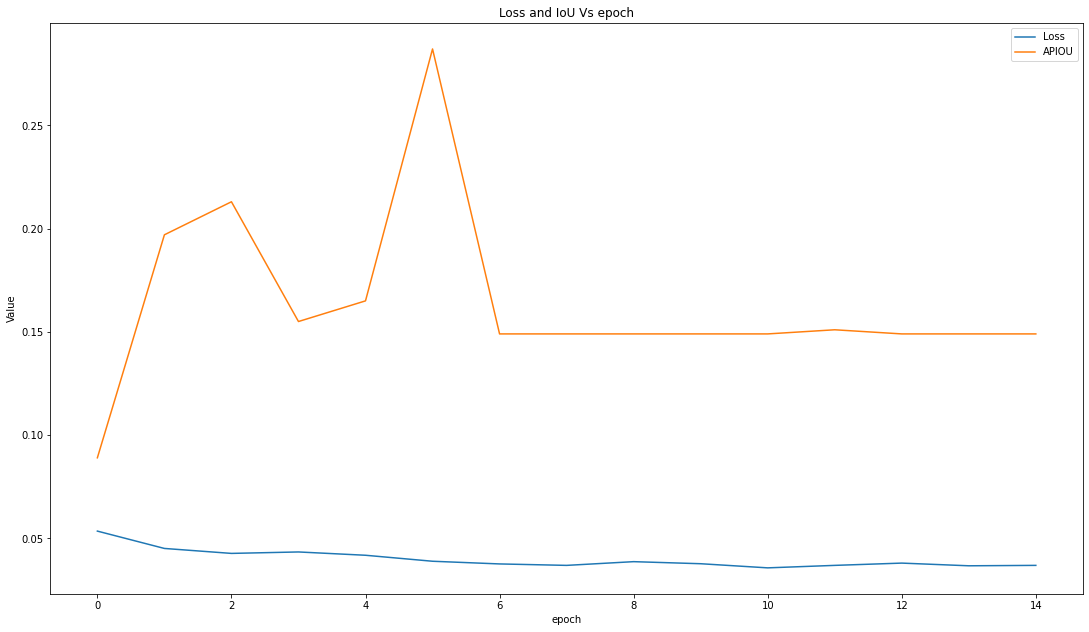

In [10]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.plot(loss, label='Loss')
plt.plot(APIOU, label='APIOU')
 
plt.title("Loss and IoU Vs epoch")
plt.xlabel("epoch")
plt.ylabel("Value")
 
plt.legend()
plt.show()

In [12]:
import pandas as pd

all = deeplabv3 = [
    {
    'Model': 'DeepLabV3-Resnet18',
    'Loss': 0.4196537733078003,
    'IoU': 0.6994313597679138,
    },
    {
    'Model': 'DeepLabV3-Resnet50',
    'Loss': 0.4123762547969818,
    'IoU': 0.7262035608291626,
    },
    {
    'Model': 'DeepLabV3-Resnet101',
    'Loss': 0.39198556542396545,
    'IoU': 0.721318781375885,
    },
    {
    'Model': "U-net",
    'Loss': 0.3642409145832062,
    'IoU': 0.7161526679992676,
    },
    {
    "Model": "SegNet",
    'Loss': 1, #2.837581056,
    'IoU': 0.47706034779548645,
    },
    {
    "Model": "MaskRCNN",
    "Loss": 0.0369,
    "IoU": 0.149,
    }
    
]


alldf = pd.DataFrame(all)
alldf

,Model,Loss,IoU
0,DeepLabV3-Resnet18,0.419654,0.699431
1,DeepLabV3-Resnet50,0.412376,0.726204
2,DeepLabV3-Resnet101,0.391986,0.721319
3,U-net,0.364241,0.716153
4,SegNet,1.000000,0.477060
5,MaskRCNN,0.036900,0.149000


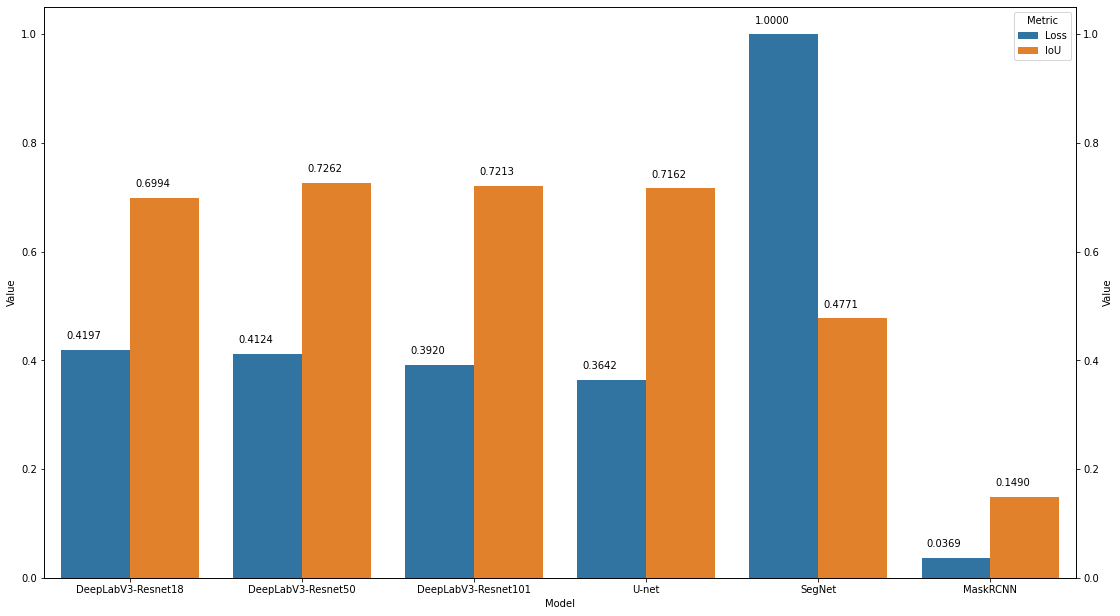

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_data_melted = pd.melt(alldf, id_vars="Model",\
                           var_name="Metric", value_name="Metrics")
# Plot
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)
g = sns.barplot(x=alldf.columns[0], y="Metrics", hue="Metric",\
                data=test_data_melted, ax=ax1)

# Create a second y-axis with the scaled ticks
ax1.set_ylabel('Value')
ax2 = ax1.twinx()

# Ensure ticks occur at the same positions, then modify labels
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round(ax1.get_yticks(),1))
ax2.set_ylabel('Value')

for i, p in enumerate(ax1.patches):
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/4.+0.03, height + 0.02, "{:.4f}".format(test_data_melted['Metrics'][i]),ha="center")
plt.show()


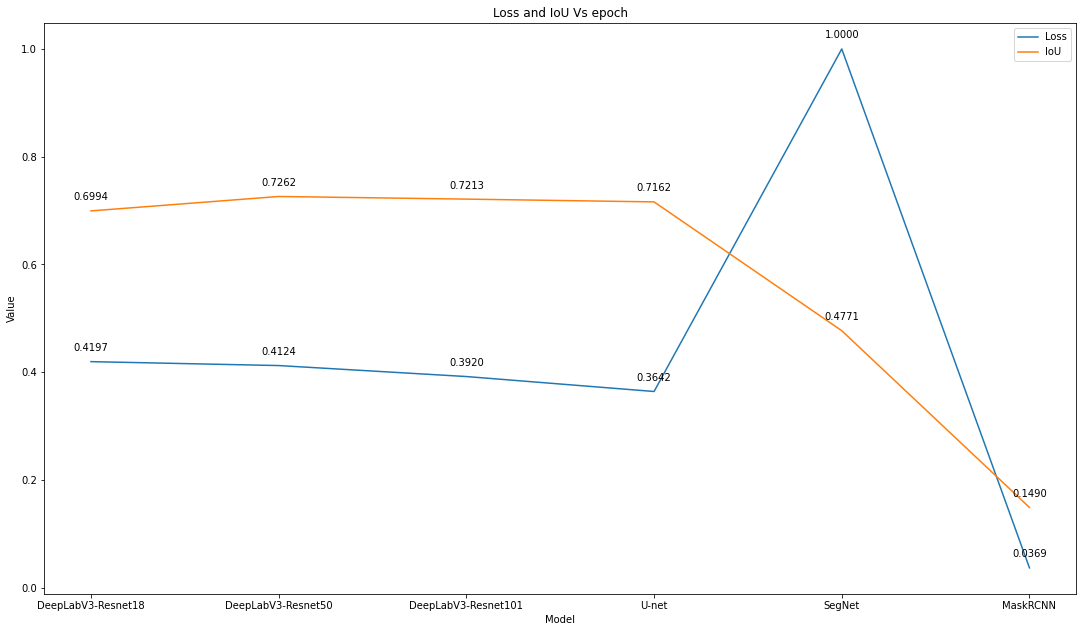

In [35]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.plot(alldf['Loss'], label='Loss')
for i, v in enumerate(alldf['Loss']):
    ax1.text(i, v+0.02, "%.4f" %v, ha="center")
plt.plot(alldf['IoU'], label='IoU')
for i, v in enumerate(alldf['IoU']):
    ax1.text(i, v+0.02, "%.4f" %v, ha="center")
models = alldf['Model'].values
models = np.concatenate(([0],models))
plt.title("Loss and IoU Vs epoch")
plt.xlabel("Model")
plt.ylabel("Value")
ax1.set_xticklabels(models)
plt.legend()
plt.show()